In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from Configs.Configs import BraninConfig
from Core.Dataset import BraninDataset
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tqdm.notebook as tqdm

In [3]:
config=BraninConfig()

## Dataset

In [7]:
dataset=BraninDataset(config)

n_eval_pts=500
eval_data = dataset.GetEvalData(n_eval_pts)

In [8]:
x=eval_data['x']
y=eval_data['y']

x1_grid_n=x[:, 0].reshape(n_eval_pts, n_eval_pts)
x2_grid_n=x[:, 1].reshape(n_eval_pts, n_eval_pts)
y_grid=y.reshape(n_eval_pts, n_eval_pts)

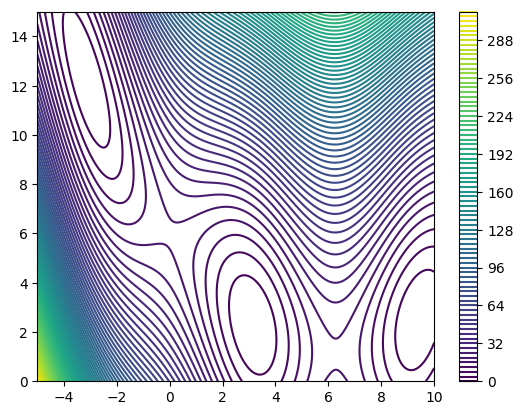

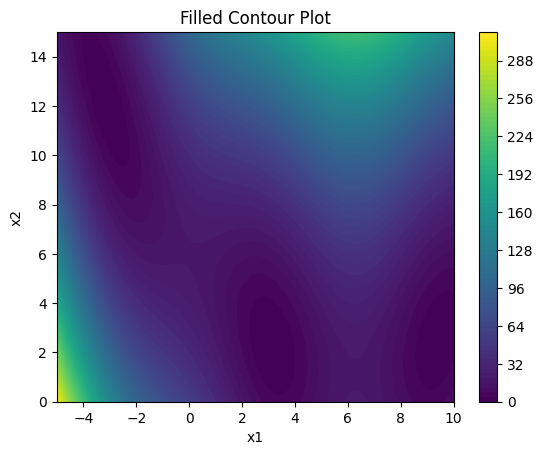

In [9]:
plt.contour(x1_grid_n, x2_grid_n, y_grid, 100)
plt.colorbar()

# Create filled contour plot
plt.figure()
contour = plt.contourf(x1_grid_n, x2_grid_n, y_grid, 100)
plt.colorbar(contour)
plt.title('Filled Contour Plot')
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()

## Noise Schedule

In [10]:
def diffusion_noise_schedule(n_steps, beta_range):
    beta=torch.linspace(beta_range[0], beta_range[1], n_steps)
    alpha=1-beta
    alpha_bar=torch.cumprod(alpha, dim=0)
    om_alpha_bar=1-alpha_bar
    return alpha_bar.sqrt(), om_alpha_bar.sqrt()

def get_act_fn(act_fn):
    return {'relu':nn.ReLU, 'tanh':nn.Tanh}[act_fn]

class ResNet(nn.Module):
    def __init__(self, inp_dim, hid_dim, act_fn) -> None:
        super().__init__()
        self.lin1=nn.Linear(inp_dim, hid_dim)
        self.bn1=nn.BatchNorm1d(hid_dim)
        self.act1=get_act_fn(act_fn)()
        
        self.lin2=nn.Linear(hid_dim, inp_dim)
        self.bn2=nn.BatchNorm1d(inp_dim)
        self.act2=get_act_fn(act_fn)()
        
    def forward(self, inp):
        temp_inp=self.lin1(inp)
        temp_inp=self.bn1(temp_inp)
        temp_inp=self.act1(temp_inp)
        
        temp_inp=self.lin2(temp_inp)
        temp_inp=self.bn2(temp_inp)
        out=self.act2(temp_inp+inp)
        return out

In [11]:
beta_range = (1e-4, 0.02)
n_steps=100

In [12]:
beta=torch.linspace(beta_range[0], beta_range[1], n_steps)

In [13]:
alpha=1-beta
alpha_bar=torch.cumprod(alpha, dim=0)
one_minus_alpha_bar=1-alpha_bar

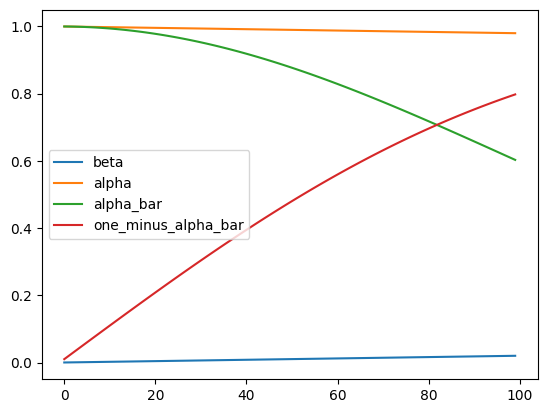

In [14]:
plt.plot(range(n_steps), beta, label="beta")
plt.plot(range(n_steps), alpha, label="alpha")
# plt.plot(range(n_steps), alpha_bar, label="alpha_bar")
# plt.plot(range(n_steps), one_minus_alpha_bar, label="one_minus_alpha_bar")
plt.plot(range(n_steps), alpha_bar.sqrt(), label="alpha_bar")
plt.plot(range(n_steps), one_minus_alpha_bar.sqrt(), label="one_minus_alpha_bar")
plt.legend()

## NNModel

## Final Train Tests

In [11]:
from Core.Branin import BraninDDPM
from Configs.Configs import BraninConfig

In [12]:
config=BraninConfig()
config.run_number=1

In [13]:
branin=BraninDDPM(config)

initializing NNModel
untrained model


In [14]:
branin.model.nn_model.n_hid_dim

128

In [11]:
# branin.train()

In [ ]:
for ep in range(1):
    for ind, batch_data in enumerate(dataloader):
        optim.zero_grad()
        loss=model(batch_data['x'], batch_data['y'])
        loss.backward()
        print(loss)

## Validation

In [8]:
branin=BraninDDPM(config, "SavedResults/Branin/run1/train/int_model_199.pt")

using trained model


In [10]:
branin.model.nn_model.n_drop_prob

AttributeError: 'NNModel' object has no attribute 'n_drop_prob'

### Sampling

In [39]:
n_test_points=100
y_value=128.0

noisy_x=torch.randn((n_test_points, config.inp_dim))
test_y=torch.ones((n_test_points, config.out_dim))*y_value
t_indices=torch.ones((n_test_points, 1))

cond_wt_ind=0
mode="eval"

In [40]:
# branin.model.nn_model(x_t, )

In [42]:
x_t=torch.randn((n_test_points, config.inp_dim))
for it in range(config.n_time-1, -1, -1):
    t_indices = torch.ones((n_test_points, 1))*it/config.n_time
    noise_pred_cond=branin.model.nn_model(x_t, test_y, t_indices, mode)
    noise_pred_uncond=branin.model.nn_model(x_t, None, t_indices, mode)
    noise_pred=((1 + config.conditioning_weights[cond_wt_ind])*noise_pred_cond
                + config.conditioning_weights[cond_wt_ind]*noise_pred_uncond)
    x_t=(x_t - (1-alpha_t)*noise_pred/((1 - alpha_bar_t).sqrt()))/sqrt(alpha_t)+torch.randn_like(x_t)
    

AttributeError: 'NNModel' object has no attribute 'n_hid_dim'

In [36]:
## Assuming model is trained
out=branin.model.nn_model(noisy_x, test_y, t_indices)

In [37]:
noisy_x-out

torch.Size([100, 2])

In [9]:
assert False, "a"

AssertionError: a

## BraninDDPM Tests

In [22]:
from Core.Branin import BraninDDPM
from Configs.Configs import BraninConfig

In [23]:
config = BraninConfig()

br = BraninDDPM()

In [24]:
br.train(config, 2)

  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 0
batch number: 0
exiting batch loop
exiting epoch loop
Training complete


In [25]:
model_path = "Models/Branin/run2/train/final_model_0.pt"
br.load_pretrained_model(model_path)

In [27]:
n_test_points=100
target_y=128.0

cond_wt=0

test = br.sample(target_y, n_test_points, cond_wt)

In [13]:
a = torch.ones(5)*6

In [14]:
a.sqrt()

tensor([2.4495, 2.4495, 2.4495, 2.4495, 2.4495])

In [17]:
b = torch.tensor([1, 2, 3, 4, 5])

In [18]:
a/b

tensor([6.0000, 3.0000, 2.0000, 1.5000, 1.2000])